# CLIP コサイン類似度サンプリング可視化（JAX/Flax実装）

このノートブックは、DreamerV3環境からサンプルした画像に対して、
JAX実装のCLIP（FlaxCLIPModel）で「画像-言語」「画像-画像」の
コサイン類似度を計算し、結果を並べて表示します。

手順:
1. 設定名とサンプル数を指定
2. 環境から画像をサンプリング
3. CLIPで埋め込みを生成
4. テキスト/画像クエリでランキング表示


In [10]:
!nvidia-smi

Thu Dec 25 14:50:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GB10                    On  |   0000000F:01:00.0 Off |                  N/A |
| N/A   42C    P0             10W /  N/A  | Not Supported          |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [11]:
import jax

print(jax.default_backend())
print(jax.devices())

gpu
[CudaDevice(id=0)]


In [2]:
from __future__ import annotations

import math

import jax
import jax.numpy as jnp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import ruamel.yaml as yaml
import elements
from transformers import CLIPProcessor, FlaxCLIPModel
from tqdm import tqdm

import dreamerv3.main as d3main


def load_config(config_name: str):
    """Load DreamerV3 config by name.

    Args:
        config_name: Config name in dreamerv3/configs.yaml.

    Returns:
        elements.Config merged with defaults.
    """
    config_path = elements.Path("/home/ist_baidoku/yoshinari.kawashima/wm25_final_homework/dreamerv3/dreamerv3/configs.yaml")
    configs = yaml.YAML(typ="safe").load(config_path.read())
    config = elements.Config(configs["defaults"])
    config = config.update(configs[config_name])
    return config


def to_pil_image(image):
    """Convert input image array to RGB PIL image.

    Args:
        image: Numpy array or PIL.Image.

    Returns:
        PIL.Image in RGB mode.
    """
    if isinstance(image, Image.Image):
        return image.convert("RGB")
    array = np.asarray(image)
    if array.ndim == 2:
        array = np.repeat(array[:, :, None], 3, axis=-1)
    if array.shape[-1] == 1:
        array = np.repeat(array, 3, axis=-1)
    if array.dtype != np.uint8:
        if array.max() <= 1.0:
            array = (array * 255.0).astype(np.uint8)
        else:
            array = np.clip(array, 0, 255).astype(np.uint8)
    return Image.fromarray(array)


def sample_env_images(env, num_images, image_key="image", seed=0):
    """Sample images by stepping the env with random actions.

    Args:
        env: embodied.Env instance.
        num_images: Number of images to collect.
        image_key: Observation key that contains the image.
        seed: RNG seed for numpy.

    Returns:
        List of numpy arrays.
    """
    np.random.seed(seed)
    images = []
    action = {k: v.sample() for k, v in env.act_space.items() if k != "reset"}
    action["reset"] = True
    obs = env.step(action)
    images.append(obs[image_key])
    while len(images) < num_images:
        action = {k: v.sample() for k, v in env.act_space.items() if k != "reset"}
        action["reset"] = bool(obs.get("is_last", False))
        obs = env.step(action)
        images.append(obs[image_key])
    return images


def plot_image_grid(images, scores=None, title=None, max_cols=8):
    """Plot images in a grid with index numbers and optional scores.

    Args:
        images: List of images (numpy arrays).
        scores: Optional list/array of scores aligned with images.
        title: Optional figure title.
        max_cols: Max columns in grid.

    Returns:
        None.
    """
    if not images:
        print("No images to display.")
        return
    count = len(images)
    cols = min(count, max_cols)
    rows = math.ceil(count / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))

    if count == 1:
        axes = np.array([axes])
    axes = np.array(axes).reshape(rows, cols)

    for idx in range(rows * cols):
        ax = axes.flat[idx]
        ax.axis("off")
        if idx >= count:
            continue

        img = to_pil_image(images[idx])
        ax.imshow(img)

        label = f"idx: {idx}"
        if scores is not None:
            label += f"{scores[idx]:.3f}"
        ax.set_title(label, fontsize=8)

    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()


def l2norm(x, axis=-1, eps=1e-6):
    """L2-normalize feature vectors.

    Args:
        x: Array of shape (..., D).
        axis: Axis to normalize.
        eps: Small epsilon to avoid divide-by-zero.

    Returns:
        Normalized array.
    """
    return x / (jnp.linalg.norm(x, axis=axis, keepdims=True) + eps)


def encode_images(model, processor, images, batch_size=16):
    """Encode images into CLIP embeddings.

    Args:
        model: FlaxCLIPModel instance.
        processor: CLIPProcessor instance.
        images: List of images (numpy arrays or PIL).
        batch_size: Batch size.

    Returns:
        jnp.ndarray of shape (N, D).
    """
    batches = []
    for start in tqdm(range(0, len(images), batch_size)):
        batch_images = [to_pil_image(img) for img in images[start : start + batch_size]]
        inputs = processor(images=batch_images, return_tensors="np")
        feats = model.get_image_features(**inputs)
        feats = l2norm(feats)
        batches.append(feats)
    if not batches:
        return jnp.zeros((0, 0), dtype=jnp.float32)
    return jnp.concatenate(batches, axis=0)


def encode_texts(model, processor, texts):
    """Encode texts into CLIP embeddings.

    Args:
        model: FlaxCLIPModel instance.
        processor: CLIPProcessor instance.
        texts: List of text strings.

    Returns:
        jnp.ndarray of shape (N, D).

    Raises:
        ValueError: If texts is empty.
    """
    if not texts:
        raise ValueError("texts must be a non-empty list.")
    inputs = processor(text=texts, return_tensors="np", padding=True)
    feats = model.get_text_features(**inputs)
    return l2norm(feats)


def cosine_scores(image_embs, query_emb):
    """Compute cosine similarity scores between images and a query.

    Args:
        image_embs: Array of shape (N, D), normalized.
        query_emb: Array of shape (D,) or (1, D), normalized.

    Returns:
        Numpy array of shape (N,).
    """
    if query_emb.ndim == 1:
        query_emb = query_emb[None, :]
    scores = image_embs @ query_emb.T
    scores = scores.squeeze(-1)
    return np.asarray(jax.device_get(scores))


def rank_indices(scores, exclude_indices=None):
    """Rank indices by score ascending.

    Args:
        scores: Score array.
        exclude_indices: Optional iterable of indices to exclude.

    Returns:
        Numpy array of indices sorted ascending by score.
    """
    scores = np.asarray(scores)
    indices = np.arange(scores.size)
    if exclude_indices:
        exclude = np.array(list(exclude_indices), dtype=int)
        mask = np.ones(scores.size, dtype=bool)
        mask[exclude] = False
        indices = indices[mask]
        scores = scores[mask]
    order = indices[np.argsort(scores)]
    return order


def select_top_bottom(scores, top_k, bottom_k, exclude_indices=None):
    """Select top and bottom indices from scores.

    Args:
        scores: Score array.
        top_k: Number of top items.
        bottom_k: Number of bottom items.
        exclude_indices: Optional iterable of indices to exclude.

    Returns:
        Tuple of (top_indices, bottom_indices).
    """
    order = rank_indices(scores, exclude_indices=exclude_indices)
    top_indices = order[::-1][:top_k] if top_k else np.array([], dtype=int)
    bottom_indices = order[:bottom_k] if bottom_k else np.array([], dtype=int)
    return top_indices.tolist(), bottom_indices.tolist()


def show_ranked(images, scores, top_k=8, bottom_k=8, title="", exclude_indices=None):
    """Display top and bottom ranked images.

    Args:
        images: List of images.
        scores: Score array aligned with images.
        top_k: Number of top images to show.
        bottom_k: Number of bottom images to show.
        title: Optional label printed before plots.
        exclude_indices: Optional iterable of indices to exclude from ranking.

    Returns:
        None.
    """
    if title:
        print(title)
    top_indices, bottom_indices = select_top_bottom(scores, top_k, bottom_k, exclude_indices=exclude_indices)
    if top_indices:
        plot_image_grid(
            [images[i] for i in top_indices],
            scores=[scores[i] for i in top_indices],
            title=f"Top {len(top_indices)}",
        )
    if bottom_indices:
        plot_image_grid(
            [images[i] for i in bottom_indices],
            scores=[scores[i] for i in bottom_indices],
            title=f"Bottom {len(bottom_indices)}",
        )

In [3]:
config_name = "atari100k"  # or "dmc_vision"
image_key = "image"

num_samples = 1000
seed = 0

config = load_config(config_name)
config = config.update({"task": "atari100k_freeway"})
env = d3main.make_env(config, 0)
images = sample_env_images(env, num_samples, image_key=image_key, seed=seed)
if hasattr(env, "close"):
    env.close()
print(f"Collected {len(images)} images from {config_name}.")

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


Collected 1000 images from atari100k.


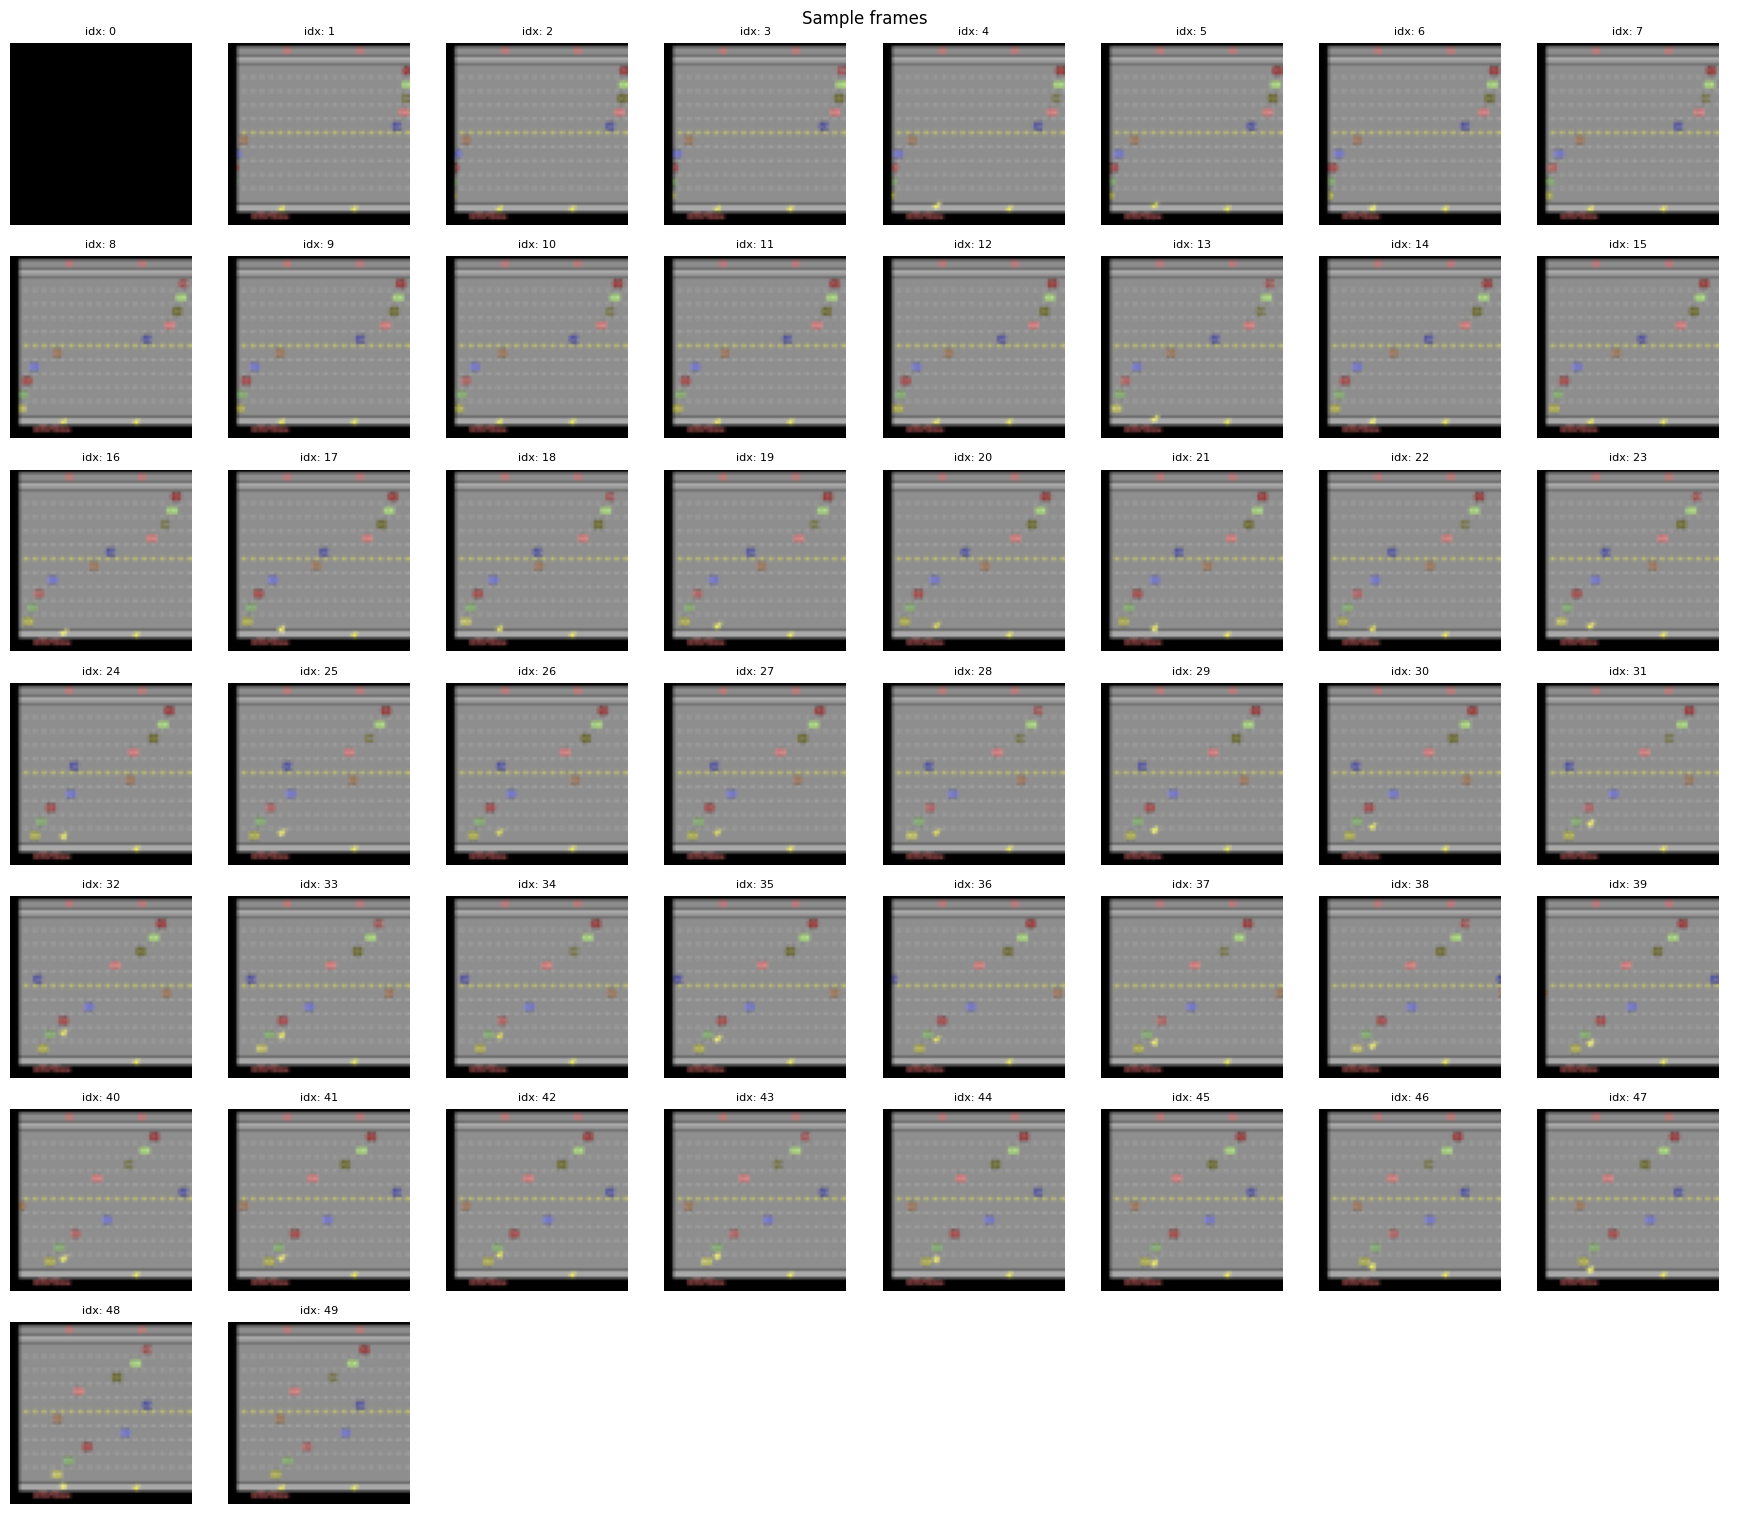

In [4]:
plot_image_grid(images[:50], title="Sample frames")

In [5]:
model_id = "openai/clip-vit-base-patch32"
model = FlaxCLIPModel.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
2025-12-25 14:46:33.795391: E external/xla/xla/service/hlo_lexer.cc:438] Failed to parse int literal: 496688471116181647782
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
batch_size = 16
image_embs = encode_images(model, processor, images, batch_size=batch_size)
print(f"Image embeddings: {tuple(image_embs.shape)}")

100%|██████████| 63/63 [00:08<00:00,  7.19it/s]

Image embeddings: (1000, 512)


Text query: "A yellow circle in the center. Colorful random objects nearby."


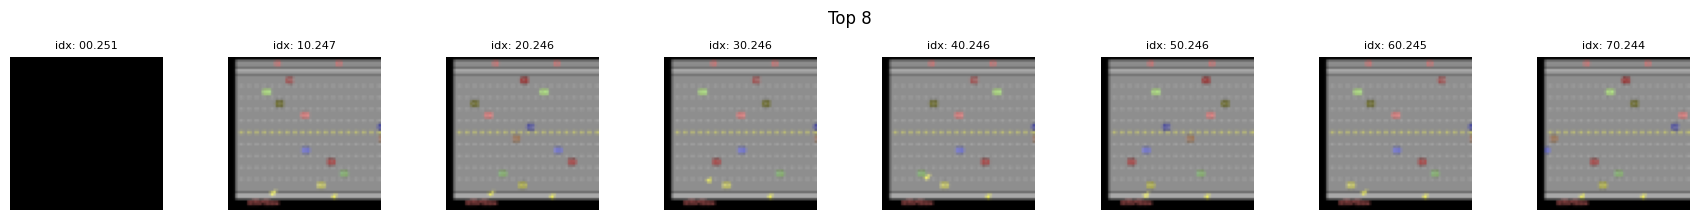

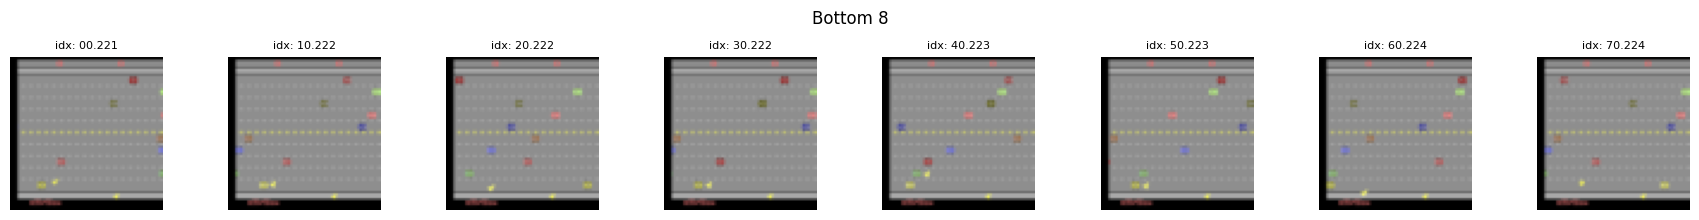

In [7]:
text_queries = [
    "A yellow circle in the center. Colorful random objects nearby.",
    "a pong game",
    "a simple colorful scene",
    "a close-up of a character",
]
query_index = 0
top_k = 8
bottom_k = 8

text_embs = encode_texts(model, processor, text_queries)
query_emb = text_embs[query_index]
scores = cosine_scores(image_embs, query_emb)
show_ranked(
    images,
    scores,
    top_k=top_k,
    bottom_k=bottom_k,
    title=f'Text query: "{text_queries[query_index]}"',
)

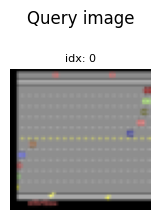

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


Image query


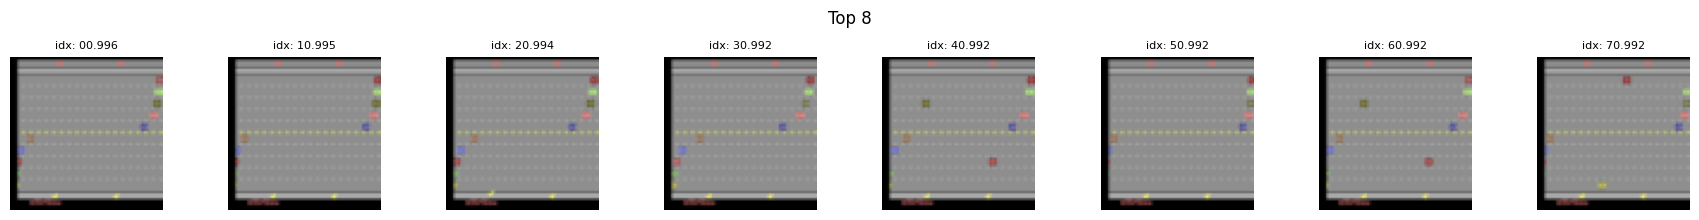

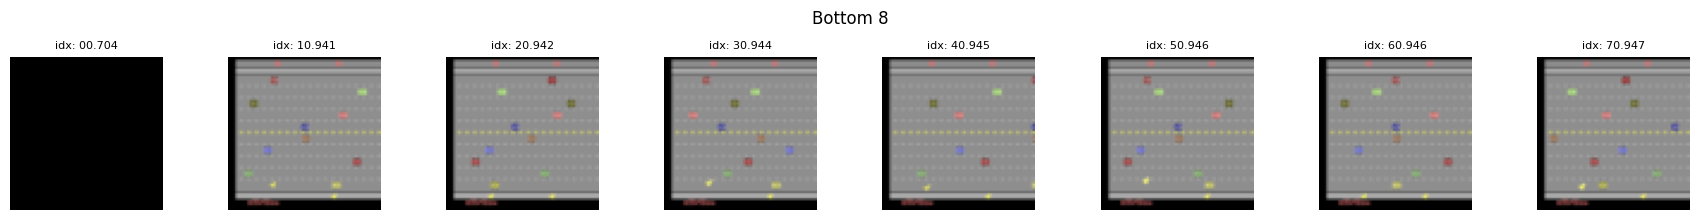

In [8]:
image_query_mode = "sample"  # "sample" or "file"
query_index = 4
query_path = "path/to/query.png"
exclude_query_from_ranking = True

if image_query_mode == "file":
    query_image = Image.open(query_path)
else:
    query_image = images[query_index]

plot_image_grid([query_image], title="Query image")

query_emb = encode_images(model, processor, [query_image], batch_size=1)[0]
scores = cosine_scores(image_embs, query_emb)
exclude = [query_index] if (image_query_mode == "sample" and exclude_query_from_ranking) else None
show_ranked(
    images,
    scores,
    top_k=top_k,
    bottom_k=bottom_k,
    title="Image query",
    exclude_indices=exclude,
)

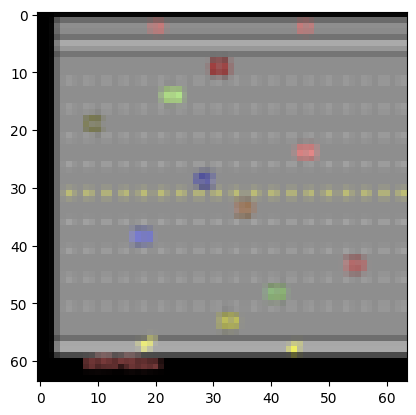

In [12]:
plt.imshow(images[100])

## 生成画像を用いたサンプリング

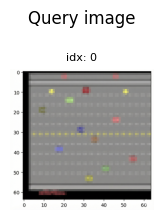

100%|██████████| 1/1 [00:00<00:00,  6.56it/s]


Image query


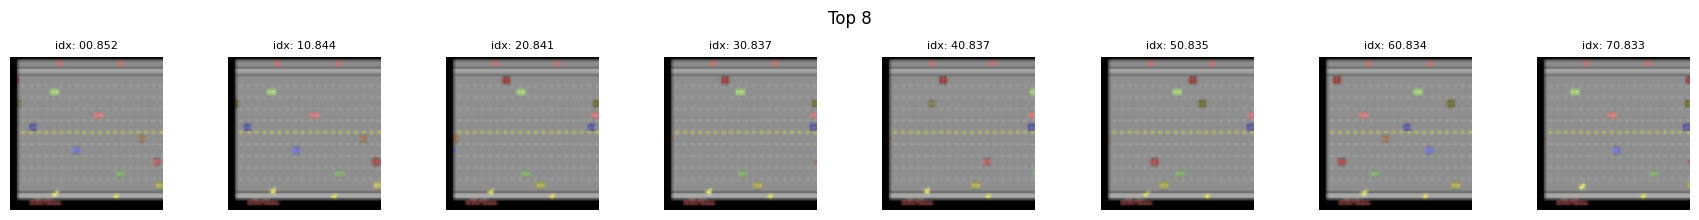

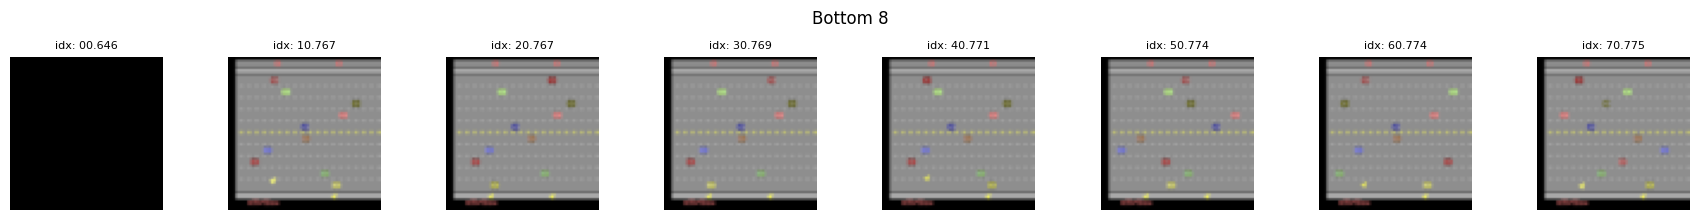

In [13]:
image_query_mode = "file"  # "sample" or "file"
query_index = 4
query_path = "images/images_generated.png"
exclude_query_from_ranking = True

if image_query_mode == "file":
    query_image = Image.open(query_path)
else:
    query_image = images[query_index]

plot_image_grid([query_image], title="Query image")

query_emb = encode_images(model, processor, [query_image], batch_size=1)[0]
scores = cosine_scores(image_embs, query_emb)
exclude = [query_index] if (image_query_mode == "sample" and exclude_query_from_ranking) else None
show_ranked(
    images,
    scores,
    top_k=top_k,
    bottom_k=bottom_k,
    title="Image query",
    exclude_indices=exclude,
)